In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from __future__ import print_function
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import itertools

from scipy.stats import mode
from sklearn.metrics import (f1_score, roc_curve, roc_auc_score)



In [25]:
!ls ../tfhub/inference

inception_v3		    mobilenet_v2_050_224_50pct
mobilenet_v2_050_224	    mobilenet_v2_050_224_5pct
mobilenet_v2_050_224_10pct  mobilenet_v2_050_224_75pct
mobilenet_v2_050_224_1pct   nasnet_large
mobilenet_v2_050_224_25pct  resnet_v2_152
mobilenet_v2_050_224_2pct


In [26]:
def draw_contour(mask, rgb):
    if rgb.shape[0] != mask.shape[0]:
        x_, y_ = mask.shape[:2]
        rgb = cv2.resize(rgb, dsize=(y_, x_))
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, 0, (0,0,0), 5)
    return rgb2

def draw_contour_all(mask, rgb):
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, -1, (0,0,0), 3)
    return rgb2

# mask_list = glob.glob('../data/validation_svs/*png')
mask_list = glob.glob('/mnt/slowdata/slide_data/durham/max_high_grade_content/*_index.png')
mask_paths = pd.DataFrame(mask_list, index=[os.path.basename(x).replace('_index.png', '') for x in mask_list])
print(len(mask_paths))

32


# Evaluate performance

In [108]:
BACKGROUND = 255
SKIP_CODES = [4,5,6,7, 255]
def get_regions(mask, thresh=500):
#     label_images = {x: np.zeros_like(mask) for x in range(5)}
    label_images = []
    label_codes = []
    
    labels = np.unique(mask)
    image = (mask < BACKGROUND).astype(np.uint8)
    
    _, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
    for cnt_num, _ in enumerate(contours):
        dummy_image = np.zeros_like(mask)
        cv2.drawContours(dummy_image, contours, cnt_num, 1, -1)
        ## Check area -- 
        pos_area = dummy_image.sum()
        if pos_area < thresh:
            continue
        dummy_image = dummy_image.astype(np.bool)
        cnt_label = mode(mask[dummy_image])[0][0]
        if cnt_label in SKIP_CODES:
            continue
        else:
            label_images.append(np.copy(dummy_image))
            label_codes.append(cnt_label)
        
    return label_images, label_codes

def load_mask(p):
    mask = cv2.imread(p, -1)
    # Reassign high grade=2 into high grade=1
    mask[mask==2] = 1
    
    return mask

def load_prob(p, mask_x, mask_y, interp=cv2.INTER_LINEAR):
    x = np.load(p)
    if x.shape[-1] == 5:
        x_x, x_y = x.shape[:2]
        x_cpy = np.zeros((x_x, x_y, 4), dtype=x.dtype)
        x_cpy[:,:,0] = x[:,:,0]
        x_cpy[:,:,1] = x[:,:,1]+x[:,:,2]
        x_cpy[:,:,2] = x[:,:,1]+x[:,:,3]
        x_cpy[:,:,3] = x[:,:,1]+x[:,:,4]
        x = x_cpy
    x = cv2.resize(x, dsize=(mask_y, mask_x), interpolation=interp)
    return x

def load_ensemble(paths, mask_x, mask_y, interp=cv2.INTER_LINEAR):
    probs = []
    for p in paths:
        prob = load_prob(p, mask_x, mask_y, interp=interp)
        print(p, prob.shape)
        probs.append(prob)
        
    probs = np.stack(probs, axis=0)
    prob_mean = np.mean(probs, axis=0) 
    print(prob_mean.shape)
    return prob_mean

def get_base(p):
    b = os.path.basename(p).replace('_prob.npy', '')
    return b
        
    
def glob_ensembles(glob_patterns):
    inf_lists = []
    inf_base_lists = []
    for gp in glob_patterns:
        infl = sorted(glob.glob(gp))
        inf_lists.append(infl)
        
        infb = np.asarray([get_base(infp) for infp in infl])
        inf_base_lists.append(infb)
    
    running_intersection = np.intersect1d(*inf_base_lists[:2])
    for inf_pair in itertools.combinations(inf_base_lists, 2):
        inf_base_intersect = np.intersect1d(*inf_pair)
        running_intersection = np.intersect1d(running_intersection, inf_base_intersect)
        
    print(running_intersection)
    print(len(running_intersection))
    running_intersection = [infb for infb in running_intersection if infb in mask_paths.index]
    print(running_intersection)
    print(len(running_intersection))
    
    reduced_inf_lists = []
    for infl in inf_lists:
        rinfl = [infp for infp in infl if get_base(infp) in running_intersection]
        reduced_inf_lists.append(rinfl)
    
    # Rearrange: [outputs, *[paths]] --> [base, *[outputs]]
    rearranged_lists = []
    for ix in range(len(reduced_inf_lists[0])):
        all_paths = []
        for rinfl in reduced_inf_lists:
            all_paths.append(rinfl[ix])
        rearranged_lists.append(all_paths)
        
    return rearranged_lists
        

# grade_dict = {0: 'G3', 1: 'G4', 2: 'G5', 3: 'BN', 4: 'ST'}
grade_dict = {0: 'G3', 1: 'HG',  2: 'BN', 3: 'ST'}
attrib = ['Region', 'Slide', 'Region_area', 'TotalAcc', 'EpitheliumAcc', 
          'EpitheliumF1', 'Class_Label', 'Stroma_Area']
attrib += ['{}'.format(x) for y,x in grade_dict.items()]

def perform_comparison(glob_path, out_base='.', ensemble=False):
    performance = {k: [] for k in attrib}
    
    if ensemble:
        inf_list = glob_ensembles(glob_patterns=glob_path)
    else:
        inf_list = glob.glob(glob_path)
        print('Found output files: ', len(inf_list))
        ## Reduce to slides we have annotated
        inf_bases = [os.path.basename(infp).replace('_prob.npy', '') for infp in inf_list]
        inf_list = [infp for infp, infb in zip(inf_list, inf_bases) if infb in mask_paths.index]
        
    print('Found matching output/annotations: ', len(inf_list))

    for idx, inf_path in enumerate(inf_list):
        if ensemble:
            inf_base = get_base(inf_path[0])
        else:
            inf_base = get_base(inf_path)

        mask = load_mask(mask_paths.loc[inf_base,0])
        mask_x, mask_y = mask.shape[:2]
        
        if ensemble:
            x = load_ensemble(inf_path, mask_x, mask_y)
        else:
            x = load_prob(inf_path, mask_x, mask_y)
            
        
        # For TFHUB comparison, shift the classes down one
        mask[mask == 2] = 1
        mask[mask == 3] = 2
        mask[mask > 4] = 255
        
        label_images, label_codes = get_regions(mask)

        amax = np.argmax(x, axis=-1)
        amax[mask==255] = 255

        ## Loop over the present classes:
        region = 0
        for LI, LC in zip(label_images, label_codes):
            ## pull out annotated area
            amax_region = amax[LI]
            total_size = float(amax_region.shape[0])

            ## pull out non-stroma
            stroma_area = (amax_region == 3).sum()
            amax_region = amax_region[amax_region != 3]
            non_stroma_size = float(amax_region.shape[0])

            ## Reassign 2 --> 1 ( G5 / 4+5 --> G4 )
            ## Comment out for 4-class classifiers
#             amax_region[amax_region == 2] = 1

#             if LC == 2: LC = 1
            gt_region = np.zeros_like(amax_region) + LC
            total_acc = (amax_region == LC).sum() / total_size
            epithelium_acc = (amax_region == LC).sum() / non_stroma_size
            epithelium_f1 = f1_score(gt_region, amax_region, average='weighted')

            performance['Region'].append('{}_{:02d}'.format(inf_base, region))
            performance['Slide'].append(inf_base)
            performance['Region_area'].append(total_size)
            performance['TotalAcc'].append(total_acc)
            performance['EpitheliumAcc'].append(epithelium_acc)
            performance['EpitheliumF1'].append(epithelium_f1)
            performance['Class_Label'].append(grade_dict[LC])
            performance['Stroma_Area'].append(stroma_area)
            for co, gr in grade_dict.items():
                performance['{}'.format(gr)].append((amax_region == co).sum())
            print(idx, region, grade_dict[LC], inf_path, 'ACC:', epithelium_acc, 'F1:', epithelium_f1)
            region += 1


    perf_df = pd.DataFrame(performance, index=performance['Region'], columns=attrib[1:])
    outpath = os.path.join(out_base, 'processed_perf_durham.csv')
    print(outpath)
    perf_df.to_csv(outpath, sep='\t')

In [38]:
## Test for the get_regions function
np.unique(mask)
mask2 = np.copy(mask)
mask2[10:100, 10:100] = 1
mask2[110:150, 110:150] = 1
label_images, label_codes = get_regions(mask2)

for LI, LC in zip(label_images, label_codes): 
    plt.figure()
    plt.matshow(LI)
    plt.title(LC)

NameError: name 'mask' is not defined

In [109]:
# glob_path = '../tfhub/inference/mobilenet_v2_050_224_75pct/*.npy'
# glob_path = '../densenet/ext_10x/durham_val/*.npy'
# perform_comparison(glob_path)

glob_patterns = [
    '../densenet/ext_5x/durham_val/*.npy',
    '../densenet/ext_10x/durham_val/*.npy',
#     '../tfhub/inference/mobilenet_v2_050_224_75pct/*.npy',
             ]
inf_lists = glob_ensembles(glob_patterns)
for ix in range(len(inf_lists[0])):
    print(inf_lists[0][ix], inf_lists[1][ix], inf_lists[2][ix])
    
perform_comparison(glob_patterns, ensemble=True)

['s10-3220-030' 's10-3291-009' 's10-3319-009' 's10-3956-034'
 's10-4510-001' 's10-4583-012' 's10-5477-001' 's10-586-000' 's10-6178-047'
 's12-1932-001' 's12-3216-004' 's12-444-004' 's12-6456-002' 's12-6575-007'
 's12-6768-004' 's12-7549-001' 's12-7902-003' 's12_1823-012'
 's12_8147-010' 's13-058-004' 's13-059-000' 's13-3170-005' 's13-3431-008'
 's13-4610-003' 's13-5643-001' 's13-764-001' 's13_2243-015' 's13_5945-034']
28
['s10-3220-030', 's10-3291-009', 's10-3319-009', 's10-3956-034', 's10-4510-001', 's10-4583-012', 's10-5477-001', 's10-586-000', 's10-6178-047', 's12-1932-001', 's12-3216-004', 's12-444-004', 's12-6456-002', 's12-6575-007', 's12-6768-004', 's12-7549-001', 's12-7902-003', 's12_1823-012', 's12_8147-010', 's13-058-004', 's13-059-000', 's13-3170-005', 's13-3431-008', 's13-4610-003', 's13-5643-001', 's13-764-001', 's13_2243-015', 's13_5945-034']
28
../densenet/ext_5x/durham_val/s10-3220-030_prob.npy ../densenet/ext_5x/durham_val/s10-3291-009_prob.npy ../densenet/ext_5x/durha

1 20 G3 ['../densenet/ext_5x/durham_val/s10-3291-009_prob.npy', '../densenet/ext_10x/durham_val/s10-3291-009_prob.npy'] ACC: 0.5747764833378488 F1: 0.7299784946236559
1 21 BN ['../densenet/ext_5x/durham_val/s10-3291-009_prob.npy', '../densenet/ext_10x/durham_val/s10-3291-009_prob.npy'] ACC: 0.9984062396197971 F1: 0.9992024842854244
1 22 BN ['../densenet/ext_5x/durham_val/s10-3291-009_prob.npy', '../densenet/ext_10x/durham_val/s10-3291-009_prob.npy'] ACC: 0.9992345674793692 F1: 0.9996171372118701
1 23 BN ['../densenet/ext_5x/durham_val/s10-3291-009_prob.npy', '../densenet/ext_10x/durham_val/s10-3291-009_prob.npy'] ACC: 0.9946073640422177 F1: 0.997296392234884
../densenet/ext_5x/durham_val/s10-3319-009_prob.npy (2467, 3112, 4)
../densenet/ext_10x/durham_val/s10-3319-009_prob.npy (2467, 3112, 4)
(2467, 3112, 4)
2 0 BN ['../densenet/ext_5x/durham_val/s10-3319-009_prob.npy', '../densenet/ext_10x/durham_val/s10-3319-009_prob.npy'] ACC: 1.0 F1: 1.0
2 1 G3 ['../densenet/ext_5x/durham_val/s10-3

(2467, 3112, 4)
4 0 BN ['../densenet/ext_5x/durham_val/s10-4510-001_prob.npy', '../densenet/ext_10x/durham_val/s10-4510-001_prob.npy'] ACC: 1.0 F1: 1.0
4 1 BN ['../densenet/ext_5x/durham_val/s10-4510-001_prob.npy', '../densenet/ext_10x/durham_val/s10-4510-001_prob.npy'] ACC: 0.999911426040744 F1: 0.9999557110589485
4 2 BN ['../densenet/ext_5x/durham_val/s10-4510-001_prob.npy', '../densenet/ext_10x/durham_val/s10-4510-001_prob.npy'] ACC: 0.9965618580232823 F1: 0.9982779687176226
4 3 BN ['../densenet/ext_5x/durham_val/s10-4510-001_prob.npy', '../densenet/ext_10x/durham_val/s10-4510-001_prob.npy'] ACC: 0.9926322288536736 F1: 0.9963024932350084
4 4 HG ['../densenet/ext_5x/durham_val/s10-4510-001_prob.npy', '../densenet/ext_10x/durham_val/s10-4510-001_prob.npy'] ACC: 0.8957992750017769 F1: 0.9450359928014397
4 5 HG ['../densenet/ext_5x/durham_val/s10-4510-001_prob.npy', '../densenet/ext_10x/durham_val/s10-4510-001_prob.npy'] ACC: 0.7409895630120952 F1: 0.8512280357730637
4 6 BN ['../densene

(2103, 2614, 4)
11 0 BN ['../densenet/ext_5x/durham_val/s12-444-004_prob.npy', '../densenet/ext_10x/durham_val/s12-444-004_prob.npy'] ACC: 0.998329220645692 F1: 0.9991639118634476
11 1 HG ['../densenet/ext_5x/durham_val/s12-444-004_prob.npy', '../densenet/ext_10x/durham_val/s12-444-004_prob.npy'] ACC: 0.00744717700034638 F1: 0.014784253051401066
11 2 BN ['../densenet/ext_5x/durham_val/s12-444-004_prob.npy', '../densenet/ext_10x/durham_val/s12-444-004_prob.npy'] ACC: 0.9922640700204914 F1: 0.9961170157631619
11 3 BN ['../densenet/ext_5x/durham_val/s12-444-004_prob.npy', '../densenet/ext_10x/durham_val/s12-444-004_prob.npy'] ACC: 0.9989764923402007 F1: 0.9994879841440251
11 4 HG ['../densenet/ext_5x/durham_val/s12-444-004_prob.npy', '../densenet/ext_10x/durham_val/s12-444-004_prob.npy'] ACC: 0.024378953865144267 F1: 0.047597529748456095
11 5 HG ['../densenet/ext_5x/durham_val/s12-444-004_prob.npy', '../densenet/ext_10x/durham_val/s12-444-004_prob.npy'] ACC: 0.0 F1: 0.0
11 6 BN ['../dense

13 8 BN ['../densenet/ext_5x/durham_val/s12-6575-007_prob.npy', '../densenet/ext_10x/durham_val/s12-6575-007_prob.npy'] ACC: 0.9997756373628793 F1: 0.9998878060953794
13 9 BN ['../densenet/ext_5x/durham_val/s12-6575-007_prob.npy', '../densenet/ext_10x/durham_val/s12-6575-007_prob.npy'] ACC: 1.0 F1: 1.0
13 10 BN ['../densenet/ext_5x/durham_val/s12-6575-007_prob.npy', '../densenet/ext_10x/durham_val/s12-6575-007_prob.npy'] ACC: 0.9129948789934753 F1: 0.9545188949735702
13 11 BN ['../densenet/ext_5x/durham_val/s12-6575-007_prob.npy', '../densenet/ext_10x/durham_val/s12-6575-007_prob.npy'] ACC: 1.0 F1: 1.0
../densenet/ext_5x/durham_val/s12-6768-004_prob.npy (2391, 2863, 4)
../densenet/ext_10x/durham_val/s12-6768-004_prob.npy (2391, 2863, 4)
(2391, 2863, 4)
14 0 BN ['../densenet/ext_5x/durham_val/s12-6768-004_prob.npy', '../densenet/ext_10x/durham_val/s12-6768-004_prob.npy'] ACC: 1.0 F1: 1.0
14 1 BN ['../densenet/ext_5x/durham_val/s12-6768-004_prob.npy', '../densenet/ext_10x/durham_val/s12-

../densenet/ext_5x/durham_val/s12_1823-012_prob.npy (2668, 3859, 4)
../densenet/ext_10x/durham_val/s12_1823-012_prob.npy (2668, 3859, 4)
(2668, 3859, 4)
17 0 BN ['../densenet/ext_5x/durham_val/s12_1823-012_prob.npy', '../densenet/ext_10x/durham_val/s12_1823-012_prob.npy'] ACC: 0.9908506429277942 F1: 0.9954042976027823
17 1 BN ['../densenet/ext_5x/durham_val/s12_1823-012_prob.npy', '../densenet/ext_10x/durham_val/s12_1823-012_prob.npy'] ACC: 0.8688734345891977 F1: 0.9298365726731914
17 2 BN ['../densenet/ext_5x/durham_val/s12_1823-012_prob.npy', '../densenet/ext_10x/durham_val/s12_1823-012_prob.npy'] ACC: 0.9998941966883563 F1: 0.9999470955454449
17 3 HG ['../densenet/ext_5x/durham_val/s12_1823-012_prob.npy', '../densenet/ext_10x/durham_val/s12_1823-012_prob.npy'] ACC: 0.47904720312915355 F1: 0.6477781129847039
17 4 HG ['../densenet/ext_5x/durham_val/s12_1823-012_prob.npy', '../densenet/ext_10x/durham_val/s12_1823-012_prob.npy'] ACC: 0.09090909090909091 F1: 0.1666666666666667
17 5 G3 ['

../densenet/ext_5x/durham_val/s13-059-000_prob.npy (2655, 3486, 4)
../densenet/ext_10x/durham_val/s13-059-000_prob.npy (2655, 3486, 4)
(2655, 3486, 4)
20 0 BN ['../densenet/ext_5x/durham_val/s13-059-000_prob.npy', '../densenet/ext_10x/durham_val/s13-059-000_prob.npy'] ACC: 1.0 F1: 1.0
20 1 BN ['../densenet/ext_5x/durham_val/s13-059-000_prob.npy', '../densenet/ext_10x/durham_val/s13-059-000_prob.npy'] ACC: 0.9935504675910997 F1: 0.9967648010352638
20 2 BN ['../densenet/ext_5x/durham_val/s13-059-000_prob.npy', '../densenet/ext_10x/durham_val/s13-059-000_prob.npy'] ACC: 0.984754178613889 F1: 0.9923185341789992
20 3 BN ['../densenet/ext_5x/durham_val/s13-059-000_prob.npy', '../densenet/ext_10x/durham_val/s13-059-000_prob.npy'] ACC: 1.0 F1: 1.0
20 4 BN ['../densenet/ext_5x/durham_val/s13-059-000_prob.npy', '../densenet/ext_10x/durham_val/s13-059-000_prob.npy'] ACC: 0.235202837508313 F1: 0.3808327351040919
20 5 G3 ['../densenet/ext_5x/durham_val/s13-059-000_prob.npy', '../densenet/ext_10x/du

../densenet/ext_10x/durham_val/s13-5643-001_prob.npy (2492, 3112, 4)
(2492, 3112, 4)
24 0 HG ['../densenet/ext_5x/durham_val/s13-5643-001_prob.npy', '../densenet/ext_10x/durham_val/s13-5643-001_prob.npy'] ACC: 0.0 F1: 0.0
24 1 BN ['../densenet/ext_5x/durham_val/s13-5643-001_prob.npy', '../densenet/ext_10x/durham_val/s13-5643-001_prob.npy'] ACC: 0.9276032530696858 F1: 0.9624420913302447
24 2 BN ['../densenet/ext_5x/durham_val/s13-5643-001_prob.npy', '../densenet/ext_10x/durham_val/s13-5643-001_prob.npy'] ACC: 0.9981226533166458 F1: 0.9990604447228312
24 3 BN ['../densenet/ext_5x/durham_val/s13-5643-001_prob.npy', '../densenet/ext_10x/durham_val/s13-5643-001_prob.npy'] ACC: 0.8950205573321152 F1: 0.9446024781833083
24 4 HG ['../densenet/ext_5x/durham_val/s13-5643-001_prob.npy', '../densenet/ext_10x/durham_val/s13-5643-001_prob.npy'] ACC: 0.0026944995044598614 F1: 0.005374517374517375
24 5 HG ['../densenet/ext_5x/durham_val/s13-5643-001_prob.npy', '../densenet/ext_10x/durham_val/s13-5643-

../densenet/ext_5x/durham_val/s13_5945-034_prob.npy (2468, 2988, 4)
../densenet/ext_10x/durham_val/s13_5945-034_prob.npy (2468, 2988, 4)
(2468, 2988, 4)
27 0 HG ['../densenet/ext_5x/durham_val/s13_5945-034_prob.npy', '../densenet/ext_10x/durham_val/s13_5945-034_prob.npy'] ACC: 0.7437477125777724 F1: 0.8530450904257181
27 1 HG ['../densenet/ext_5x/durham_val/s13_5945-034_prob.npy', '../densenet/ext_10x/durham_val/s13_5945-034_prob.npy'] ACC: 0.6150735161951325 F1: 0.7616662771415534
27 2 HG ['../densenet/ext_5x/durham_val/s13_5945-034_prob.npy', '../densenet/ext_10x/durham_val/s13_5945-034_prob.npy'] ACC: 0.7352820812627887 F1: 0.8474496327740718
27 3 BN ['../densenet/ext_5x/durham_val/s13_5945-034_prob.npy', '../densenet/ext_10x/durham_val/s13_5945-034_prob.npy'] ACC: 1.0 F1: 1.0
27 4 HG ['../densenet/ext_5x/durham_val/s13_5945-034_prob.npy', '../densenet/ext_10x/durham_val/s13_5945-034_prob.npy'] ACC: 0.4066196766561514 F1: 0.5781515549715287
27 5 HG ['../densenet/ext_5x/durham_val/s1

In [80]:
# perf_df = pd.read_csv('../densenet/ext_5x/durham_val/processed_perf_durham.csv', header=0, index_col=0, sep='\t')
# perf_df = pd.read_csv('../densenet/ext_10x/durham_val/processed_perf_durham.csv', header=0, index_col=0, sep='\t')
# perf_df = pd.read_csv('../tfhub/inference/mobilenet_v2_050_224_75pct/processed_perf_durham.csv', header=0, index_col=0, sep='\t')

perf_df = pd.read_csv('../densenet_small/20x_FOV/inference/processed_perf.csv', header=0, index_col=0, sep='\t')
# perf_df = pd.read_csv('./processed_perf_durham.csv', header=0, index_col=0, sep='\t')
perf_df

,Slide,Region_area,TotalAcc,EpitheliumAcc,EpitheliumF1,Class_Label,Stroma_Area,G3,G4,G5,BN,ST
1304706_00,1304706,25685.0,0.296165,0.830368,0.907323,G3,16524,7607,39,0,1515,0
1304706_01,1304706,132537.0,0.353577,0.920505,0.958607,G3,81628,46862,999,0,3048,0
1304732_00,1304732,1386626.0,0.414937,0.893221,0.943599,G3,742482,575363,35435,0,33346,0
1304700_00,1304700,449236.0,0.278012,0.841835,0.914127,G3,300878,124893,829,0,22635,0
1305445_00,1305445,219890.0,0.431279,0.749492,0.856811,G4,93359,12771,94834,0,18926,0
1304716_00,1304716,173672.0,0.309653,0.626776,0.770574,G3,87871,53778,1667,0,30355,0
1304715_00,1304715,173485.0,0.190362,0.536268,0.698144,G3,111902,33025,7363,0,21195,0
1304717_00,1304717,706714.0,0.215643,0.438367,0.609535,G3,359065,152398,153475,0,40785,0
1304725_00,1304725,66066.0,0.328535,0.662222,0.796792,G3,33290,21705,294,0,10777,0
1304725_01,1304725,72009.0,1.000000,1.000000,1.000000,G3,0,72009,0,0,0,0


(90,)
0.9549595141700404


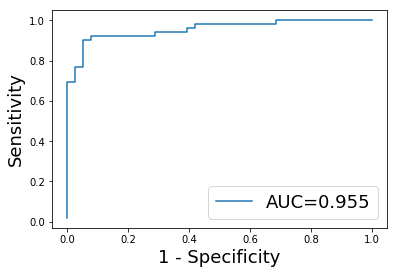

In [82]:
HG_SCORE = np.squeeze(np.asarray([perf_df.G4 / (perf_df.Region_area - perf_df.Stroma_Area)]))
# HG_SCORE = np.squeeze(np.asarray([perf_df.G4 / (perf_df.Region_area)]))
print(HG_SCORE.shape)
is_hg = np.squeeze(np.asarray(perf_df.Class_Label == 'G4').astype(np.uint8))
fpr, tpr, thresholds = roc_curve(is_hg, HG_SCORE)
auc = roc_auc_score(is_hg, HG_SCORE)
print(auc)
plt.plot(fpr, tpr, label='AUC={:3.3f}'.format(auc))
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
# plt.title('Benign ROC', fontsize=18)
plt.legend(fontsize=18)


In [44]:
x20_g3_fpr = fpr
x20_g3_tpr = tpr
x20_g3_auc = auc

In [41]:
x5_g3_fpr = fpr
x5_g3_tpr = tpr
x5_g3_auc = auc

In [83]:
x20_fpr = fpr
x20_tpr = tpr
x20_auc = auc

In [37]:
x5_fpr = fpr
x5_tpr = tpr
x5_auc = auc

In [183]:
g4_fpr = fpr
g4_tpr = tpr
g4_auc = auc

In [185]:
g3_fpr = fpr
g3_tpr = tpr
g3_auc = auc

In [177]:
bn_fpr = fpr
bn_tpr = tpr
bn_auc = auc

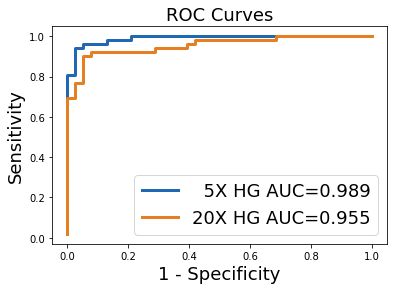

In [84]:
plt.plot(x5_fpr, x5_tpr, label='  5X HG AUC={:3.3f}'.format(x5_auc),              c=( 32/255., 105/255., 178/255. ), lw=3)
# plt.plot(x5_g3_fpr, x5_g3_tpr, label='  5X LG AUC={:3.3f}'.format(x5_g3_auc),     c=(214/255.,  38/255., 38/255.), lw=3)
plt.plot(x20_fpr, x20_tpr, label='20X HG AUC={:3.3f}'.format(x20_auc),          c=( 229/255., 127/255., 32/255. ), lw=3, )
# plt.plot(x20_g3_fpr, x20_g3_tpr, label='20X LG AUC={:3.3f}'.format(x20_g3_auc), c=(214/255.,  38/255., 38/255.), lw=3, ls='--')
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
plt.title('ROC Curves', fontsize=18)
plt.legend(fontsize=18)

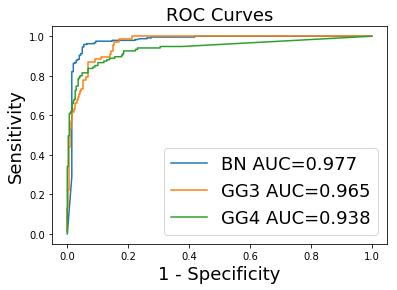

In [188]:
plt.plot(bn_fpr, bn_tpr, label='BN AUC={:3.3f}'.format(bn_auc))
plt.plot(g3_fpr, g3_tpr, label='GG3 AUC={:3.3f}'.format(g3_auc))
plt.plot(g4_fpr, g4_tpr, label='GG4 AUC={:3.3f}'.format(g4_auc))
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
plt.title('ROC Curves', fontsize=18)
plt.legend(fontsize=18)

In [162]:
for thr in np.linspace(0, 1, 20):
    positive_hg = np.asarray([perf_df.HG > thr*(perf_df.Region_area - perf_df.Stroma_Area)])
    true_hg_pos = np.asarray(perf_df.Class_Label == 'HG')

    a = np.sum(positive_hg * true_hg_pos)

    ppv = float(a) / np.sum(true_hg_pos)
    
    negative_hg = np.asarray([perf_df.HG < thr*(perf_df.Region_area - perf_df.Stroma_Area)])
    true_hg_neg = np.asarray([perf_df.Class_Label != 'HG'])

    d = np.sum(negative_hg * true_hg_neg)

    npv = float(d) / np.sum(true_hg_neg)
    print(thr, ppv, npv)

0.0 0.948148148148 0.0
0.05263157894736842 0.814814814815 0.941558441558
0.10526315789473684 0.748148148148 0.967532467532
0.15789473684210525 0.681481481481 0.974025974026
0.21052631578947367 0.637037037037 0.983766233766
0.2631578947368421 0.585185185185 0.993506493506
0.3157894736842105 0.518518518519 0.993506493506
0.3684210526315789 0.466666666667 0.996753246753
0.42105263157894735 0.4 0.996753246753
0.47368421052631576 0.385185185185 0.996753246753
0.5263157894736842 0.340740740741 0.996753246753
0.5789473684210527 0.303703703704 1.0
0.631578947368421 0.259259259259 1.0
0.6842105263157894 0.244444444444 1.0
0.7368421052631579 0.2 1.0
0.7894736842105263 0.148148148148 1.0
0.8421052631578947 0.0962962962963 1.0
0.894736842105263 0.0814814814815 1.0
0.9473684210526315 0.0296296296296 1.0
1.0 0.0 1.0


In [ ]:
perf_tables = glob.glob('../unet_small/*/inference/processed_perf.csv')
# perf_tables = glob.glob('../tfhub/inference/*/processed_perf.csv')
print(perf_tables)

for perf_tab in sorted(perf_tables):
    df = pd.read_csv(perf_tab, sep='\t', header=0, index_col=0)
    basename = os.path.split(perf_tab)[0]
    print(basename, df.shape, np.mean(df['EpitheliumF1']))

# Plot performance

In [ ]:
sns.boxplot(x="Class_Label", y="EpitheliumAcc", data=perf_df)
plt.ylim([0, 1.])

plt.title('F1 \n U-Net-Small 5X Combined HighGrade', fontsize=18)


# Draw masks into a figure

In [ ]:
inf_list = glob.glob('../tfhub/inference/inception_v3/*npy')

# inf_list = glob.glob('../unet/10x/inference/*npy')

rgb_list = glob.glob('../unet/10x/inference/*rgb.jpg')

rgb_paths = pd.DataFrame(rgb_list, index=[os.path.basename(x).replace('_rgb.jpg', '') for x in rgb_list])
print(len(inf_list))

# inf_path = np.random.choice(inf_list,1)[0]
inf_path = '../tfhub/inference/inception_v3/1304732_prob.npy'
inf_base = os.path.basename(inf_path).replace('_prob.npy', '')
print(inf_path, inf_base)

x = np.load(inf_path)
mask = cv2.imread(mask_paths.loc[inf_base,0], -1)
rgb = cv2.imread(rgb_paths.loc[inf_base,0], -1)[:,:,::-1]
x_, y_ = x.shape[:2]
mask = cv2.resize(mask, dsize=(y_, x_), interpolation=cv2.INTER_NEAREST)
print(mask.shape, np.unique(mask))

fig, axs = plt.subplots(2,3,figsize=(12, 8))
    
amax = np.argmax(x, axis=-1)
## Take away unannotated area
amax[mask==255] = 6
mask[mask==255] = 6

mask[0:5, 0] = np.arange(5)
amax[0:5, 0] = np.arange(5)

axs[0][0].matshow(amax, cmap='Set1')
axs[0][0].set_yticks([])
axs[0][0].set_xticks([])
axs[0][0].set_title('Prediction', fontsize=26)
axs[0][0].set_ylabel('With Stroma', fontsize=24)

axs[0][1].matshow(mask, cmap='Set1')
axs[0][1].set_yticks([])
axs[0][1].set_xticks([])
axs[0][1].set_title('Annotation', fontsize=26)

rgb_marked = draw_contour(mask, rgb)
axs[0][2].imshow(rgb_marked)
axs[0][2].set_yticks([])
axs[0][2].set_xticks([])
axs[0][2].set_title('Normalized H&E', fontsize=26)

## Take away stroma
mask[amax==4] = 6
amax[amax==4] = 6

# rgb_marked = draw_contour_all(mask, rgb)

axs[1][0].matshow(amax, cmap='Set1')
axs[1][0].set_yticks([])
axs[1][0].set_xticks([])
axs[1][0].set_ylabel('No Stroma', fontsize=24)

axs[1][1].matshow(mask, cmap='Set1')
axs[1][1].set_yticks([])
axs[1][1].set_xticks([])

axs[1][2].imshow(rgb)
axs[1][2].set_yticks([])
axs[1][2].set_xticks([])

plt.tight_layout()
plt.suptitle('Retrained Inception-V3', fontsize=24)
plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/wsi_pred_label_inception_v3.pdf', bbox_inches='tight')

## Masks

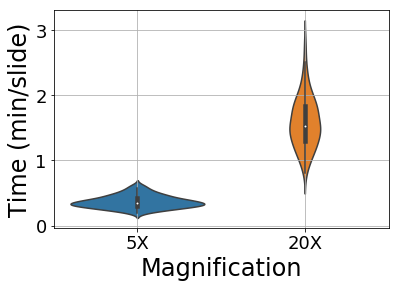

In [77]:
paths = ['../densenet_small/5x/inference/processing_time.txt', 
         '../densenet_small/20x/inference/processing_time.txt']
labels = ['5X', '20X']

dfs = {'Magnification': [], 'Time': []}
means = []
for p, l_ in zip(paths, labels):
    df = pd.read_csv(p, header=None, sep='\t')
    mean_ = np.mean(df[1])
    means.append(mean_)
    dfs['Magnification'] += [l_]*len(df)
    dfs['Time'] += list(df[1].values)

dfs = pd.DataFrame(dfs)
ax = sns.violinplot(x='Magnification', y='Time', data=dfs)
ax.set_xlabel('Magnification', fontsize=24)
# ax.set_xticks(labels, fontsize=18)
ax.set_ylabel('Time (min/slide)', fontsize=24)
# ax.set_yticks(np.linspace(0, 4, 4), labelsize=18)

plt.tick_params(axis='both', labelsize=18)
plt.grid()

In [64]:
dfs.head()

,20X,5X
0,0.80524,0.19329
1,2.00840,0.51634
2,1.70085,0.31042
3,2.02538,0.46188
4,1.10910,0.27543
